In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from src.auxiliar_functions import ejecutar_pipeline_completo
ejecutar_pipeline_completo()

c:\Users\franc\Desktop\MostoElMostro\MostoElMostro\.venv\Lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (2.14.906) or chardet (None)/charset_normalizer (3.3.2) doesn't match a supported version!
  warnings.warn(


Iniciando proceso de filtrado y unificación...

--- Procesando archivo: ../data/Totalizadores Planta 2022_2023.xlsx ---
  -> Procesando hoja: 'Consolidado KPI'
  -> Procesando hoja: 'Consolidado Produccion'
  -> Procesando hoja: 'Totalizadores Produccion'
  -> Procesando hoja: 'Consolidado EE'
  -> Procesando hoja: 'Totalizadores Energia'
  -> Procesando hoja: 'Consolidado Agua'
  -> Procesando hoja: 'Totalizadores Agua'
  -> Procesando hoja: 'Consolidado GasVapor'
  -> Procesando hoja: 'Totalizadores Gas y Vapor'
  -> Procesando hoja: 'Consolidado Aire'
  -> Procesando hoja: 'Totalizadores Aire'
  -> Procesando hoja: 'Totalizadores CO2'
  -> Procesando hoja: 'Totalizadores Efluentes'
  -> Procesando hoja: 'Totalizadores Glicol'

--- Procesando archivo: ../data/Totalizadores Planta - 2021_2023.xlsx ---
  -> Procesando hoja: 'Consolidado KPI'
  -> Procesando hoja: 'Consolidado Produccion'
  -> Procesando hoja: 'Totalizadores Produccion'
  -> Procesando hoja: 'Consolidado EE'
  -> Proces

c:\Users\franc\Desktop\MostoElMostro\MostoElMostro\src\auxiliar_functions.py:67: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agregado = df_final.groupby('DIA', as_index=False).sum(numeric_only=True)


Columnas eliminadas: ['Unnamed: 103', 'Unnamed: 67', 'Unnamed: 35', 'HL Mosto Malta', 'Kw llum/Serv L2', 'Rep Agua Cist CE', 'Unnamed: 66', 'HL Mosto Local', 'HL Mosto Fuerte', 'Unnamed: 58', 'EE Linea 5 / Hl', 'Unnamed: 54', 'HL Mosto Budweiser', 'Hl Session IPA', 'Hl Reserva 8', 'KW Linea 4', 'Unnamed: 65', 'HL Mosto Frost', 'Agua Filt FMaCist CE', 'Unnamed: 21', 'Unnamed: 123', 'Hl Reserva 7', 'VAPOR DE CALDERA 1 KG', 'Unnamed: 72', 'Unnamed: 53', 'HL Mosto Palermo', 'Unnamed: 15', 'Unnamed: 56', 'HL Mosto Bieckert', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 84', 'HL Mosto Indio', 'Red Barriles', 'Unnamed: 55', 'Unnamed: 14', 'Unnamed: 57', 'Fuel Oil Tk2 (Kg)', 'Fuel Oil Tk1 (Kg)', 'Unnamed: 22', 'Tot_Vapor_Caldera 3', ' ', 'Unnamed: 113', 'Unnamed: 16', 'Unnamed: 46']

✅ CSV generado correctamente: ../data/processed\dataset_final.csv

🔧 Procesando dataset...
['Planta (Kw)', 'Elaboracion (Kw)', 'Bodega (Kw)', 'Cocina (Kw)', 'Envasado (Kw)', 'Linea 2 (Kw)', 'Linea 3 (Kw)', 'Linea 4 (Kw

In [49]:
import pandas as pd
import numpy as np
import os

folder = '../data/processed'
filename = 'dataset_final.csv'
file_path = os.path.join(folder, filename)

try:
    df = pd.read_csv(
        file_path,
        sep=',',
        decimal='.'
    )
    df = df.sort_values(by='DIA', ignore_index=True)
    print(f"✅ DataFrame cargado exitosamente desde: {file_path}")
    print(f"Dimensiones: {df.shape}")
    print("\nPrimeras 5 filas:")
    print(df.head())

except FileNotFoundError:
    print(f"❌ Error: No se encontró el archivo en la ruta: {file_path}")
except Exception as e:
    print(f"❌ Error al leer el archivo: {e}")

✅ DataFrame cargado exitosamente desde: ../data/processed\dataset_final.csv
Dimensiones: (1183, 332)

Primeras 5 filas:
          DIA  EE Planta / Hl  EE Elaboracion / Hl  EE Bodega / Hl  \
0  2020-07-01      642.727209            47.145349       69.023256   
1  2020-07-02        7.767254             0.769609        0.798838   
2  2020-07-03        8.801205             0.862593        0.835762   
3  2020-07-04        5.175639             0.439225        0.371077   
4  2020-07-05        7.924665             0.802365        0.717787   

   EE Cocina / Hl  EE Envasado / Hl  EE Linea 2 / Hl  EE Linea 3 / Hl  \
0        0.000000         13.813953        14.578784         0.000000   
1        0.319229          2.358593         4.158962         1.506838   
2        0.260924          1.985462        39.076667         1.448962   
3        0.258048          1.442114         4.348182         1.355238   
4        0.301592          1.664726         5.125920         2.704348   

   EE Linea 4 / Hl  

In [ ]:
pd.set_option('display.max_info_columns', 400)
df.info()

for col in df.columns:
    value_counts = df[col].value_counts(dropna=False)  # incluye NaN

    if value_counts.shape[0] < 10:   # menos de 5 uniques
        print(f"\n📌 Columna: {col}")
        print(value_counts)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1183 entries, 0 to 1182
Data columns (total 332 columns):
 #    Column                           Non-Null Count  Dtype  
---   ------                           --------------  -----  
 0    DIA                              1183 non-null   object 
 1    EE Planta / Hl                   1183 non-null   float64
 2    EE Elaboracion / Hl              1183 non-null   float64
 3    EE Bodega / Hl                   1183 non-null   float64
 4    EE Cocina / Hl                   1183 non-null   float64
 5    EE Envasado / Hl                 1183 non-null   float64
 6    EE Linea 2 / Hl                  1183 non-null   float64
 7    EE Linea 3 / Hl                  1183 non-null   float64
 8    EE Linea 4 / Hl                  1183 non-null   float64
 9    EE Servicios / Hl                1183 non-null   float64
 10   EE Sala Maq / Hl                 1183 non-null   float64
 11   EE Frio / Hl                     1183 non-null   float64
 12   EE A

In [51]:
import pandas as pd

# --- Calcular resumen ---
resumen = df.describe().T
resumen['rango'] = resumen['max'] - resumen['min']
resumen_num = resumen[['min', 'max', 'rango']].apply(pd.to_numeric, errors='coerce')

# --- Ordenar por rango antes del formateo ---
resumen_ordenado = resumen_num.sort_values('rango', ascending=True)

# --- Función para formatear condicionalmente ---
def formato_condicional(x):
    if abs(x) >= 1e5 or (abs(x) > 0 and abs(x) < 1e-3):
        return f"{x:.3e}"  # Notación científica
    else:
        return f"{x:.3f}"  # Decimal normal

# --- Aplicar formato solo después del ordenamiento ---
resumen_formateado = resumen_ordenado.map(formato_condicional)

print(resumen_formateado)


                             min        max      rango
Meta EE Agua               0.000      0.553      0.553
Meta EE Caldera            0.000      0.553      0.553
Meta EE Eflu               0.000      0.553      0.553
Meta EE Resto Planta       0.000      1.050      1.050
Meta EE CO2                0.000      1.382      1.382
...                          ...        ...        ...
EE Resto Planta / Hl  -3.916e+12    284.458  3.916e+12
KW Linea 2                 0.000  3.277e+16  3.277e+16
Envasado (Kw)            347.000  3.277e+16  3.277e+16
Restos Planta (Kw)    -3.277e+16  4.738e+06  3.277e+16
Tarifa_electrica      -1.113e+08  2.358e+19  2.358e+19

[329 rows x 3 columns]


In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats 

# EDA
Vamos a comenzar analizando nuestra variable objetivo Frio(Kw).  El dataset presenta muchos outliers, para comprender mejor los patrones vamos a hacer los analisis sobre una dataset sin outliers, pero solo para comprender como se distribuyen mejor los datos.

In [53]:
def limpiar_outliers_iqr(df, columnas_a_limpiar, k=1.5):
    df_limpio = df.copy()
    
    print("Iniciando limpieza de outliers...")
    
    for columna in columnas_a_limpiar:
        if columna not in df_limpio.columns:
            continue
            
        if not pd.api.types.is_numeric_dtype(df_limpio[columna]):
            continue

        
        Q1 = df_limpio[columna].quantile(0.05)
        Q3 = df_limpio[columna].quantile(0.95)
        IQR = Q3 - Q1
        
        limite_inferior = Q1 - (k * IQR)
        limite_superior = Q3 + (k * IQR)
        
        outliers_antes = df_limpio[
            (df_limpio[columna] < limite_inferior) | 
            (df_limpio[columna] > limite_superior)
        ].shape[0]
        
        if outliers_antes > 0:
            
            df_limpio.loc[
                (df_limpio[columna] < limite_inferior) | 
                (df_limpio[columna] > limite_superior), 
                columna
            ] = np.nan


    print("Limpieza completada.")
    return df_limpio

columnas_numericas = df.select_dtypes(include=[np.number]).columns.tolist()
df_limpio = limpiar_outliers_iqr(df, columnas_numericas)

Iniciando limpieza de outliers...
Limpieza completada.


## Analisis univariado
- Analisis variable target
- Analisis variable hl_mosto
- Analisis variable Planta (Kw)
- Analisis variables categoricas (dia_semana, estación)

In [54]:
df.columns

Index(['DIA', 'EE Planta / Hl', 'EE Elaboracion / Hl', 'EE Bodega / Hl',
       'EE Cocina / Hl', 'EE Envasado / Hl', 'EE Linea 2 / Hl',
       'EE Linea 3 / Hl', 'EE Linea 4 / Hl', 'EE Servicios / Hl',
       ...
       'Tot Reposo Inferior', 'Tot  Reposo Superior', 'Anio', 'Mes', 'Dia',
       'Dia_semana', 'Temperatura_amb', 'Tarifa_electrica', 'estacion',
       'Frio (Kw) tomorrow'],
      dtype='object', length=332)

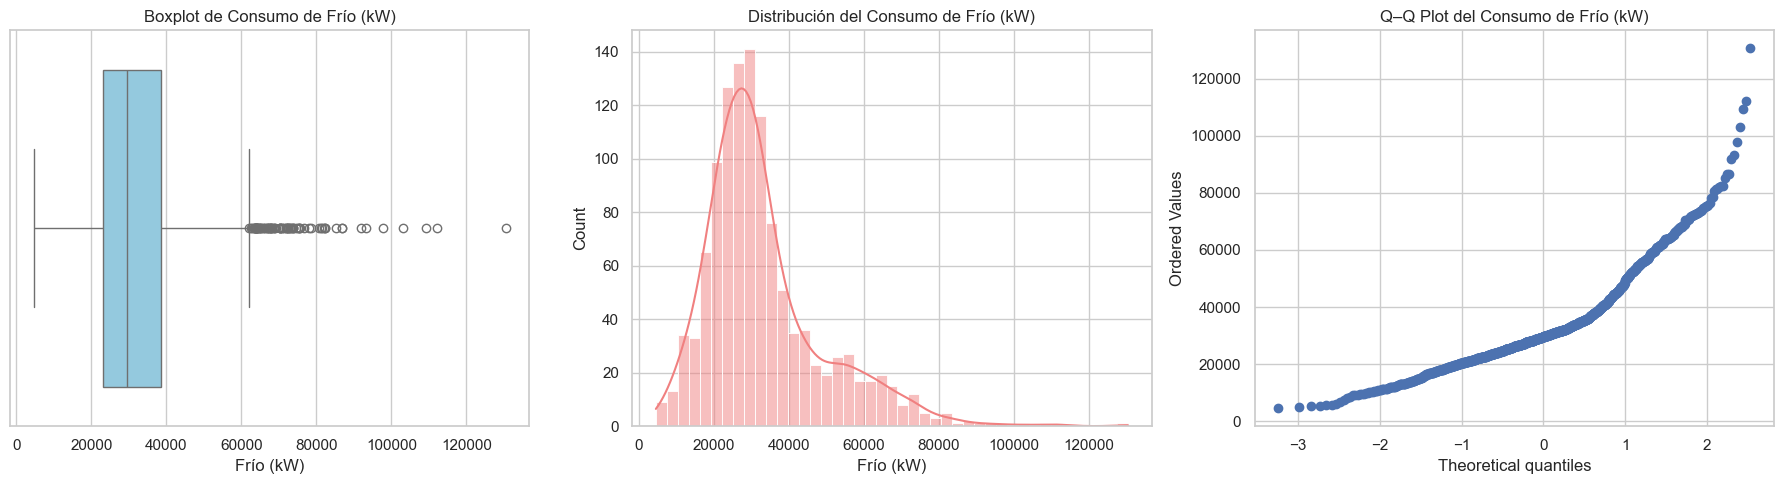

In [55]:
# Configuración de estilo
sns.set(style="whitegrid", palette="deep")

# Crear figura con tres subplots horizontales
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# --- 1. Boxplot ---
sns.boxplot(data=df_limpio, x="Frio (Kw) tomorrow", ax=axs[0], color="skyblue")
axs[0].set_title("Boxplot de Consumo de Frío (kW)")
axs[0].set_xlabel("Frío (kW)")

# --- 2. Distribución (histograma + KDE) ---
sns.histplot(data=df_limpio, x="Frio (Kw) tomorrow", kde=True, ax=axs[1], color="lightcoral")
axs[1].set_title("Distribución del Consumo de Frío (kW)")
axs[1].set_xlabel("Frío (kW)")

# --- 3. Q-Q Plot ---
stats.probplot(df_limpio["Frio (Kw) tomorrow"], dist="norm", plot=axs[2])
axs[2].set_title("Q–Q Plot del Consumo de Frío (kW)")

# Ajustar espacios
plt.tight_layout()
plt.show()


Podemos apreciar que el target se distribuye aproximadamente de manera normal y que los valores de la variable se agrupan entre 20000- 40000 Kw de consumo de Frio.
También vemos oportuno ver como se distribuyen

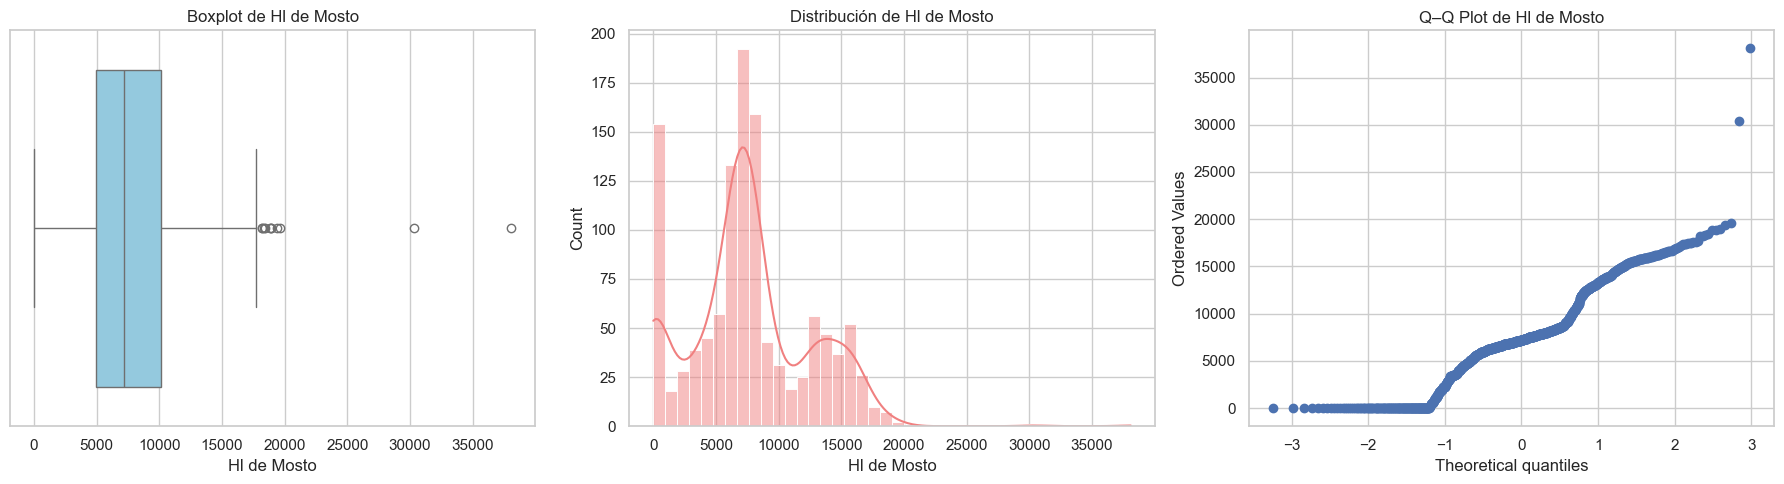

In [56]:
# Crear figura con tres subplots horizontales
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# --- 1. Boxplot ---
sns.boxplot(data=df_limpio, x="Hl de Mosto", ax=axs[0], color="skyblue")
axs[0].set_title("Boxplot de Hl de Mosto")
axs[0].set_xlabel("Hl de Mosto")

# --- 2. Distribución (histograma + KDE) ---
sns.histplot(data=df_limpio, x="Hl de Mosto", kde=True, ax=axs[1], color="lightcoral")
axs[1].set_title("Distribución de Hl de Mosto")
axs[1].set_xlabel("Hl de Mosto")

# --- 3. Q–Q Plot ---
stats.probplot(df_limpio["Hl de Mosto"], dist="norm", plot=axs[2])
axs[2].set_title("Q–Q Plot de Hl de Mosto")

# Ajustar espacios
plt.tight_layout()
plt.show()

vemos que hay muchas variables de produccion 0 de mosto, consideramos esto como una forma de no poner información sobre lo que se produjo en el dia

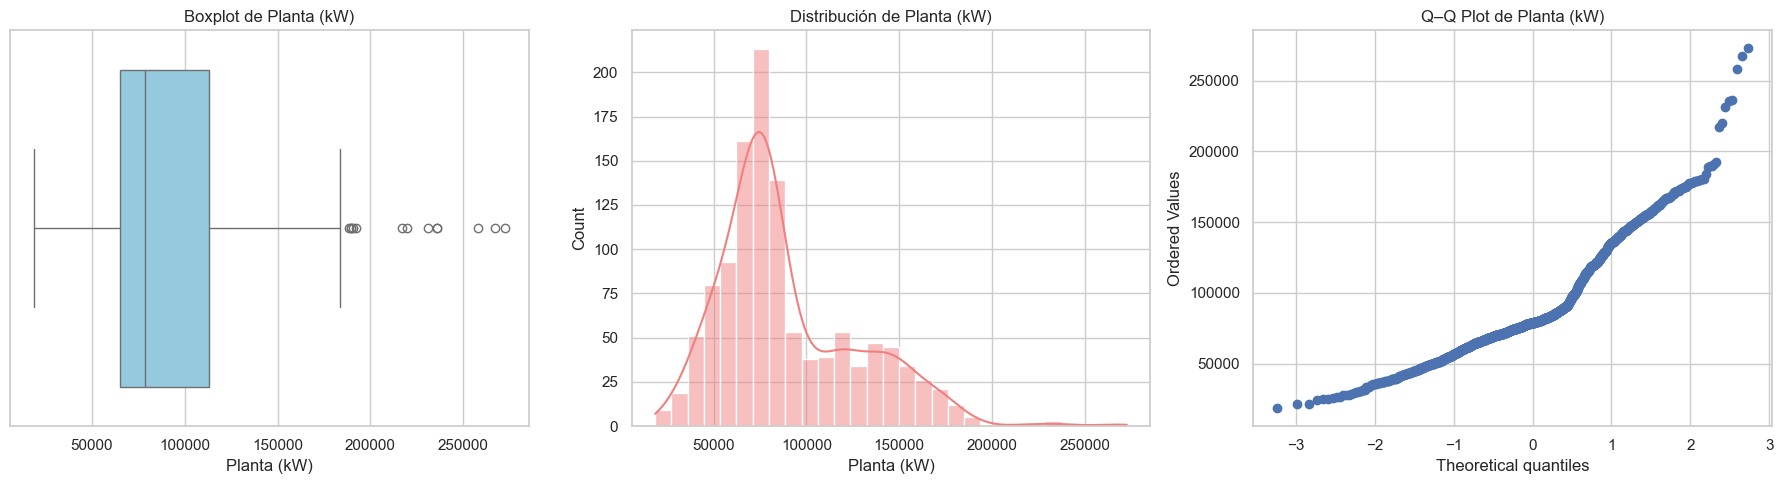

In [57]:
# Crear figura con tres subplots horizontales
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# --- 1. Boxplot ---
sns.boxplot(data=df_limpio, x="Planta (Kw)", ax=axs[0], color="skyblue")
axs[0].set_title("Boxplot de Planta (kW)")
axs[0].set_xlabel("Planta (kW)")

# --- 2. Distribución (histograma + KDE) ---
sns.histplot(data=df_limpio, x="Planta (Kw)", kde=True, ax=axs[1], color="lightcoral")
axs[1].set_title("Distribución de Planta (kW)")
axs[1].set_xlabel("Planta (kW)")

# --- 3. Q–Q Plot ---
stats.probplot(df_limpio["Planta (Kw)"], dist="norm", plot=axs[2])
axs[2].set_title("Q–Q Plot de Planta (kW)")

# Ajustar espacios
plt.tight_layout()
plt.show()

Podemos ver que el consumo de la planta y el consumo del frio tienen tendencias similares. Esto deberia ser respaldado por un coeficiente de Spearman elevado.
Mientras tanto para las variables categoricas.

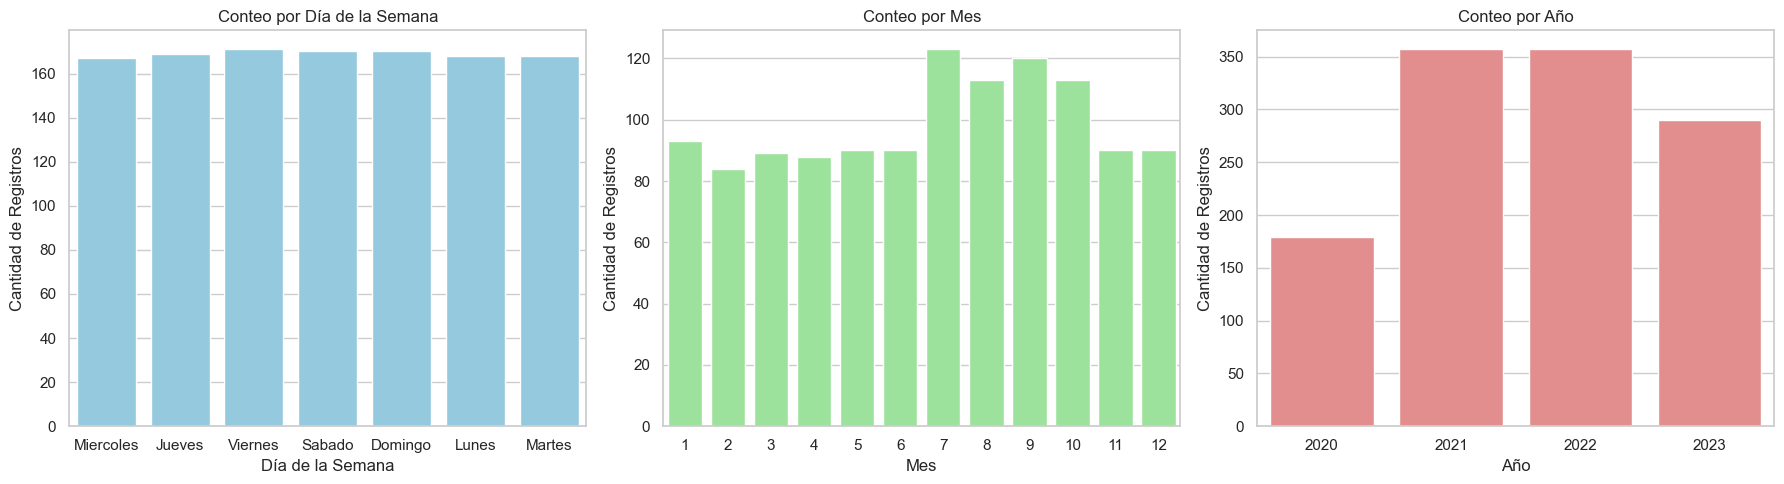

In [58]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# --- 1. Conteo por Día de la semana ---
sns.countplot(data=df_limpio, x="Dia_semana", ax=axs[0], color="skyblue")
axs[0].set_title("Conteo por Día de la Semana")
axs[0].set_xlabel("Día de la Semana")
axs[0].set_ylabel("Cantidad de Registros")

# --- 2. Conteo por Mes ---
sns.countplot(data=df_limpio, x="Mes", ax=axs[1], color="lightgreen")
axs[1].set_title("Conteo por Mes")
axs[1].set_xlabel("Mes")
axs[1].set_ylabel("Cantidad de Registros")

# --- 3. Conteo por Año ---
sns.countplot(data=df_limpio, x="Anio", ax=axs[2], color="lightcoral")
axs[2].set_title("Conteo por Año")
axs[2].set_xlabel("Año")
axs[2].set_ylabel("Cantidad de Registros")

# Ajustar el diseño
plt.tight_layout()
plt.show()

Mas o menos equilibrado los dias de la semana, los meses difieren un poco y los años falta mucha informacion respecto a 2020 porque se cominezan los datos desde julio. Lo ideal y lo que debieramos tener son la misma cantidad de observaciones en todo.

## Analisis bivariado y multivariado
Vamos a analizar:
- Analisis temporal y estacionario:
    - Consumo de Frio (Kw)
    - Produccion (Kw)
    - PLanta (Kw)
    - Hl de Mosto
- Analisis entre variables
- Analisis de correlacion:
    - entre todas
    - Respecto al Target.

### analisis temporal

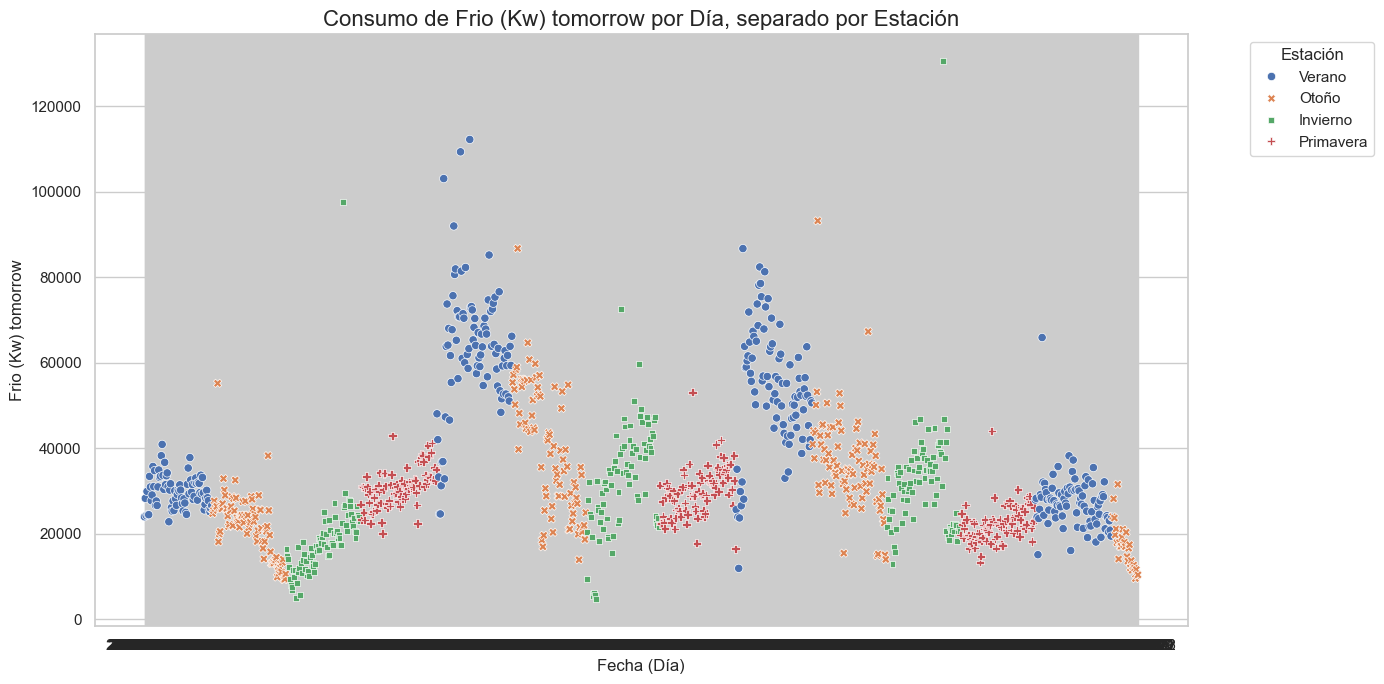

In [59]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 7))

sns.scatterplot(
    data=df_limpio,
    x='DIA',
    y='Frio (Kw) tomorrow',
    hue='estacion',
    style='estacion',  
    markers=True,      
)

plt.title('Consumo de Frio (Kw) tomorrow por Día, separado por Estación', fontsize=16)
plt.xlabel('Fecha (Día)', fontsize=12)
plt.ylabel('Frio (Kw) tomorrow', fontsize=12)

plt.legend(title='Estación', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

Podemos ver que se nota una especie de patron periodico respecto a las estaciones, por ejemplo:
- crecimiento constante en invierno, primavera y verano
- decrecimiento en otoño

Podemos analizar el rango de valores cuales oscilan las estaciones

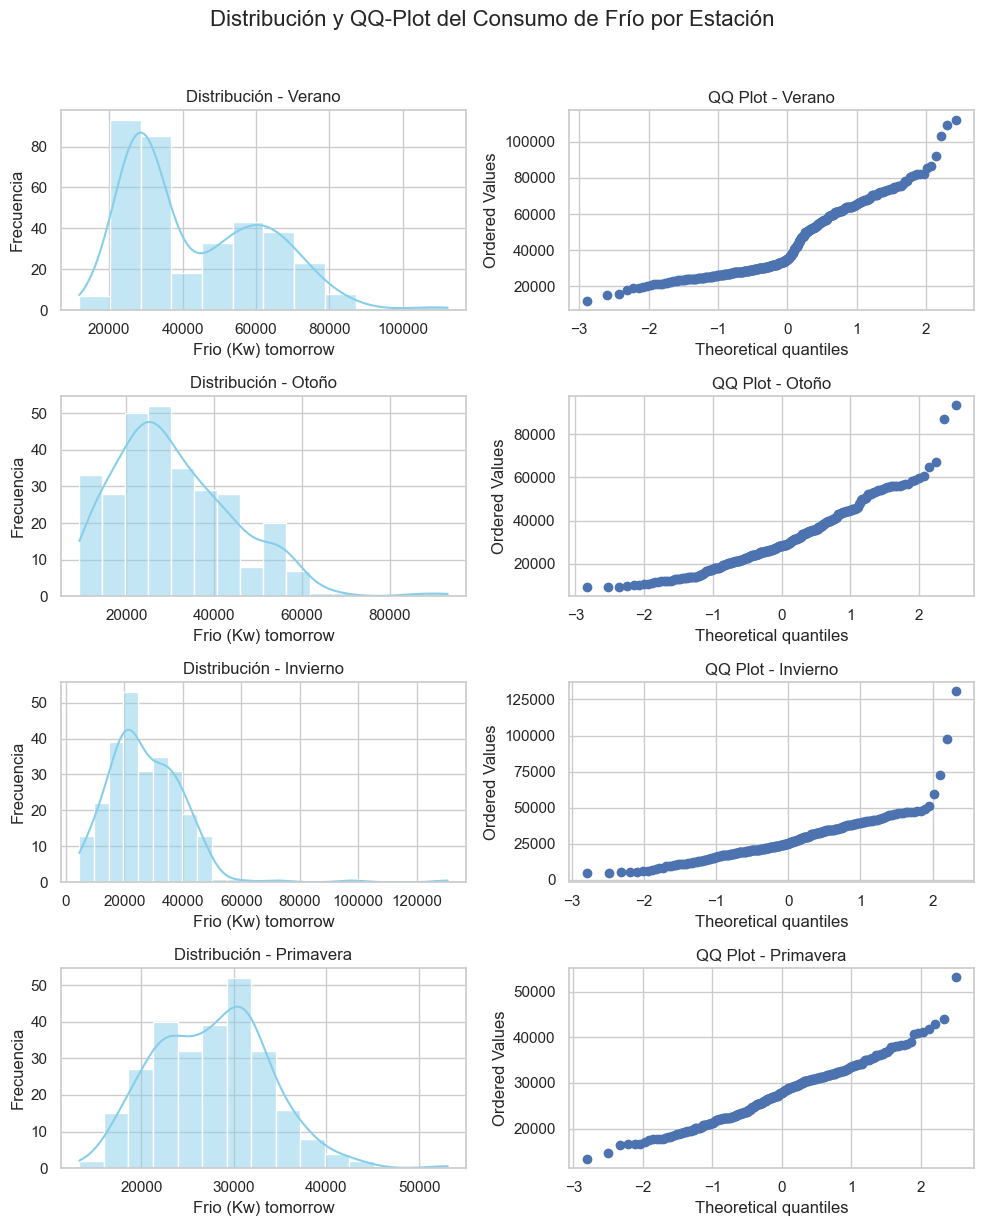

In [60]:
import scipy.stats as stats
sns.set(style="whitegrid")
estaciones = df_limpio["estacion"].unique()

fig, axes = plt.subplots(nrows=len(estaciones), ncols=2, figsize=(10, 12))
fig.suptitle("Distribución y QQ-Plot del Consumo de Frío por Estación", fontsize=16, y=1.02)

for i, estacion in enumerate(estaciones):
    datos = df_limpio[df_limpio["estacion"] == estacion]["Frio (Kw) tomorrow"]
    
    # --- Gráfico de distribución ---
    sns.histplot(datos, kde=True, ax=axes[i, 0], color="skyblue")
    axes[i, 0].set_title(f"Distribución - {estacion}")
    axes[i, 0].set_xlabel("Frio (Kw) tomorrow")
    axes[i, 0].set_ylabel("Frecuencia")

    # --- QQ Plot ---
    stats.probplot(datos, dist="norm", plot=axes[i, 1])
    axes[i, 1].set_title(f"QQ Plot - {estacion}")

plt.tight_layout()
plt.show()

Las distribuciones son aproximadamente normales a excepcion del verano que presenta como dos clusters de valores posibles.
- Se consume mas en verano y otoño que en invierno y primavera.

Podemos ver el consumo promedio que se tiene por meses

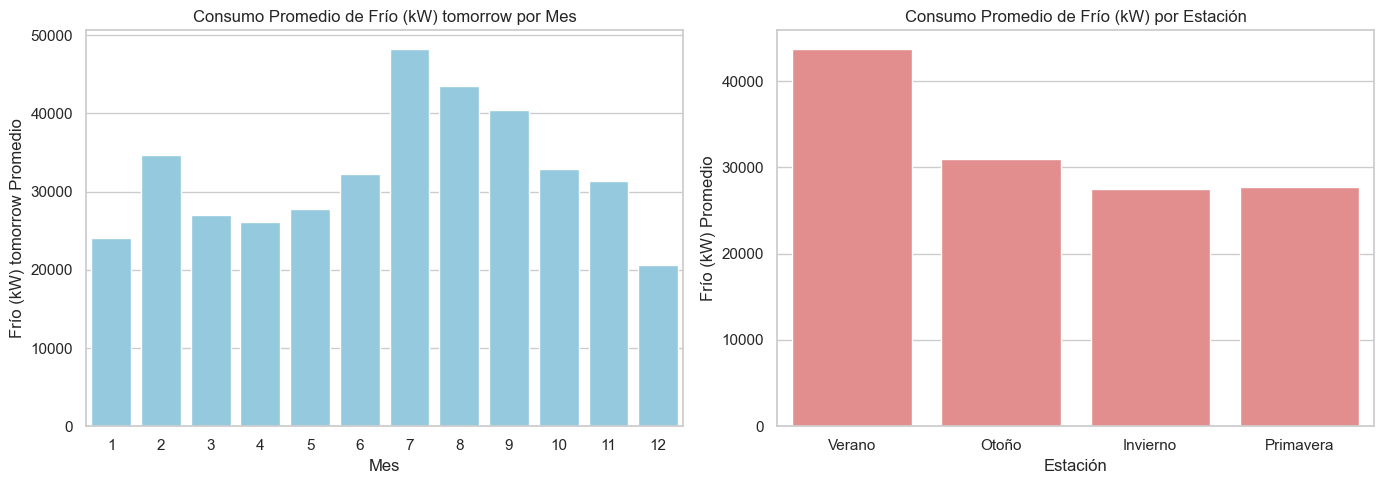

In [61]:
sns.set(style="whitegrid", palette="deep")

# Crear figura con dos subplots horizontales
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# --- 1. Promedio de Frío (kW) por Mes ---
sns.barplot(
    data=df_limpio,
    x="Mes",
    y="Frio (Kw) tomorrow",
    estimator="mean",
    errorbar =None,
    ax=axs[0],
    color="skyblue"
)
axs[0].set_title("Consumo Promedio de Frío (kW) tomorrow por Mes")
axs[0].set_xlabel("Mes")
axs[0].set_ylabel("Frío (kW) tomorrow Promedio")

# --- 2. Promedio de Frío (kW) por Estación ---
sns.barplot(
    data=df_limpio,
    x="estacion",
    y="Frio (Kw) tomorrow",
    estimator="mean",
    errorbar=None,
    ax=axs[1],
    color="lightcoral"
)
axs[1].set_title("Consumo Promedio de Frío (kW) por Estación")
axs[1].set_xlabel("Estación")
axs[1].set_ylabel("Frío (kW) Promedio")

# Ajustar el diseño
plt.tight_layout()
plt.show()

Logicamente los meses donde mas consumo de frio se necesita (probablemente en respuesta a la produccion) son los meses de verano y los meses de menor produccion (incluso por temperatura ambiente) es en invierno.

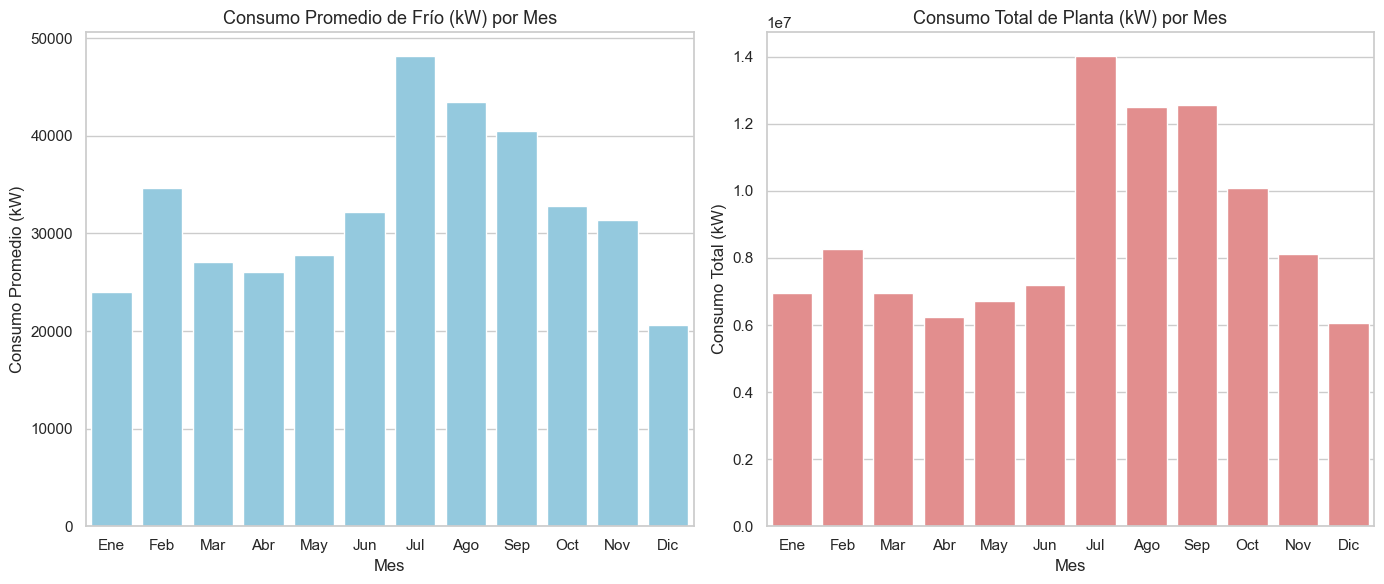

In [62]:
sns.set(style="whitegrid", palette="deep")

# --- Calcular consumo promedio mensual de frío ---
consumo_mensual = (
    df_limpio.groupby("Mes")["Frio (Kw) tomorrow"]
    .mean()
    .reset_index()
    .sort_values("Mes")
)

# --- Calcular consumo total mensual de Planta ---
planta_mensual = (
    df_limpio.groupby("Mes")["Planta (Kw)"]
    .sum()
    .reset_index()
    .sort_values("Mes")
)

# --- Crear figura con dos gráficos ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# === Gráfico 1: Consumo Promedio de Frío ===
sns.barplot(data=consumo_mensual, x="Mes", y="Frio (Kw) tomorrow", color="skyblue", ax=axes[0])
axes[0].set_title("Consumo Promedio de Frío (kW) por Mes", fontsize=13)
axes[0].set_xlabel("Mes")
axes[0].set_ylabel("Consumo Promedio (kW)")
axes[0].set_xticks(range(0, 12))
axes[0].set_xticklabels(
    ["Ene", "Feb", "Mar", "Abr", "May", "Jun",
     "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"]
)

# === Gráfico 2: Consumo Total de Planta ===
sns.barplot(data=planta_mensual, x="Mes", y="Planta (Kw)", color="lightcoral", ax=axes[1])
axes[1].set_title("Consumo Total de Planta (kW) por Mes", fontsize=13)
axes[1].set_xlabel("Mes")
axes[1].set_ylabel("Consumo Total (kW)")
axes[1].set_xticks(range(0, 12))
axes[1].set_xticklabels(
    ["Ene", "Feb", "Mar", "Abr", "May", "Jun",
     "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"]
)

plt.tight_layout()
plt.show()

Por otra parte podemos analizar temporalmente y hacer un analisis reducido similar con otras variables, como por ejemplo:
- Frio (Kw) 
- Planta (Kw) 
- Produccion (Hl) 
- Hl de Mosto

In [ ]:
sns.set(style="whitegrid", palette="deep")

# Lista de variables a analizar
variables = ["Frio (Kw) tomorrow", "Planta (Kw)", "Produccion (Hl)", "Hl de Mosto"]

# Crear figura con 4 filas × 3 columnas
fig, axs = plt.subplots(len(variables), 3, figsize=(18, 16))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Iterar sobre cada variable
for i, var in enumerate(variables):

    # --- 1. Serie temporal por día con hue estación ---
    sns.scatterplot(data=df_limpio, x="DIA", y=var, hue="estacion", ax=axs[i, 0])
    axs[i, 0].set_title(f"{var} - Serie temporal por día")
    axs[i, 0].set_xlabel("Día")
    axs[i, 0].set_ylabel(var)

    # --- 2. Promedio por Mes ---
    sns.barplot(
        data=df_limpio,
        x="Mes",
        y=var,
        estimator="mean",
        errorbar=None,
        ax=axs[i, 1],
        color="skyblue"
    )
    axs[i, 1].set_title(f"{var} - Promedio por Mes")
    axs[i, 1].set_xlabel("Mes")
    axs[i, 1].set_ylabel("Promedio")

    # --- 3. Promedio por Estación ---
    sns.barplot(
        data=df_limpio,
        x="estacion",
        y=var,
        estimator="mean",
        errorbar=None,
        ax=axs[i, 2],
        color="lightcoral"
    )
    axs[i, 2].set_title(f"{var} - Promedio por Estación")
    axs[i, 2].set_xlabel("Estación")
    axs[i, 2].set_ylabel("Promedio")

# Ajustar leyenda de la primera columna (evitar repeticiones)
for ax in axs[:, 0]:
    ax.legend(title="Estación", loc="upper right")

plt.tight_layout()
plt.show()

Los patrones se ven muy similares, lo que difiere mucho las tendencias es la produccion de mosto donde pareciera ser mas ruidosa. Quizas si los valores nulos sean rellenados, se pueden entender mejor el comportamiento.
Por otro lado, esta variable Hl de MOsto pareciera ser mas constante por estación

### Analisis Cruzado
Podemos analizar como evoluciona el consumo de Frío en función del Consumo energetico y ver la tendencia que se tiene por estación.
Se ve que a mayor consumo energetico en Verano y Primavera requiere mas consumo de Frio que en invierno qué es lógico.

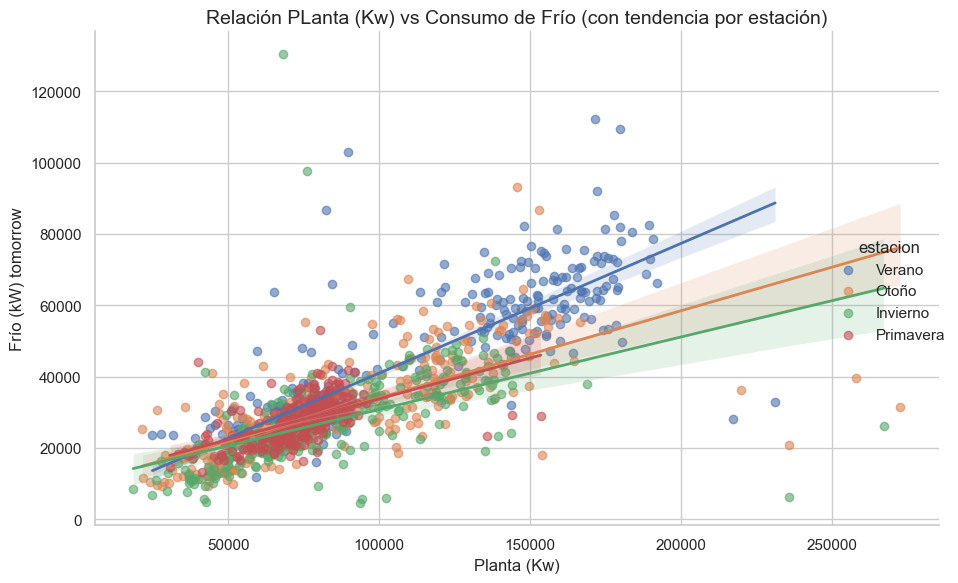

In [ ]:
sns.set(style="whitegrid")

sns.lmplot(
    data=df_limpio,
    x="Planta (Kw)",
    y="Frio (Kw) tomorrow",
    hue="estacion",
    height=6,
    aspect=1.4,
    scatter_kws={"alpha": 0.6},  
    line_kws={"lw": 2},          
)

plt.title("Relación PLanta (Kw) vs Consumo de Frío (con tendencia por estación)", fontsize=14)
plt.xlabel("Planta (Kw)")
plt.ylabel("Frío (kW) tomorrow")
plt.tight_layout()
plt.show()


De un analisis similar, podemos hacer lo mismo con los Hl de mosto y también con la Produccion (kw) de agua.
A pesar del ruido intrinseco en torno a la variable Hl_mosto, los patrones y tendencias siguen siendo similares.

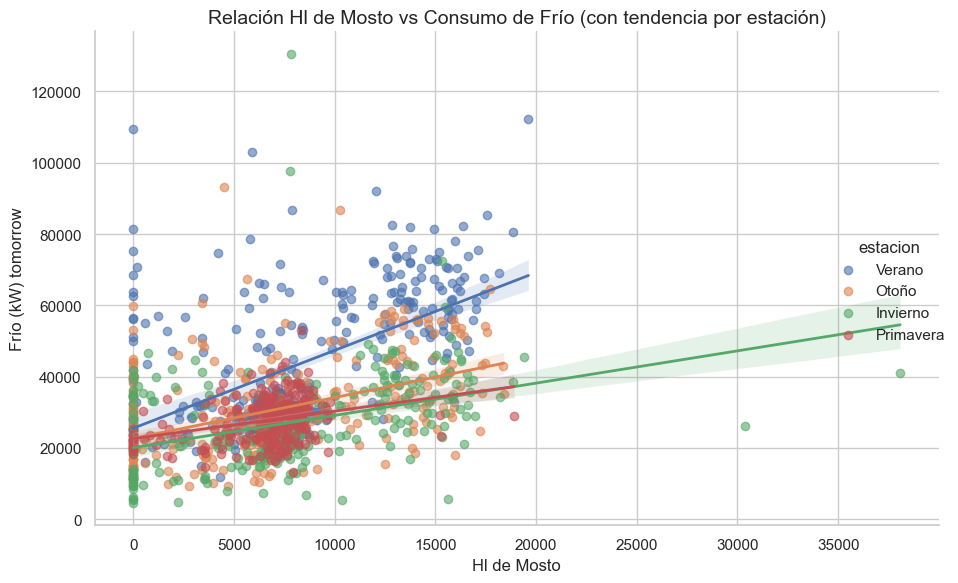

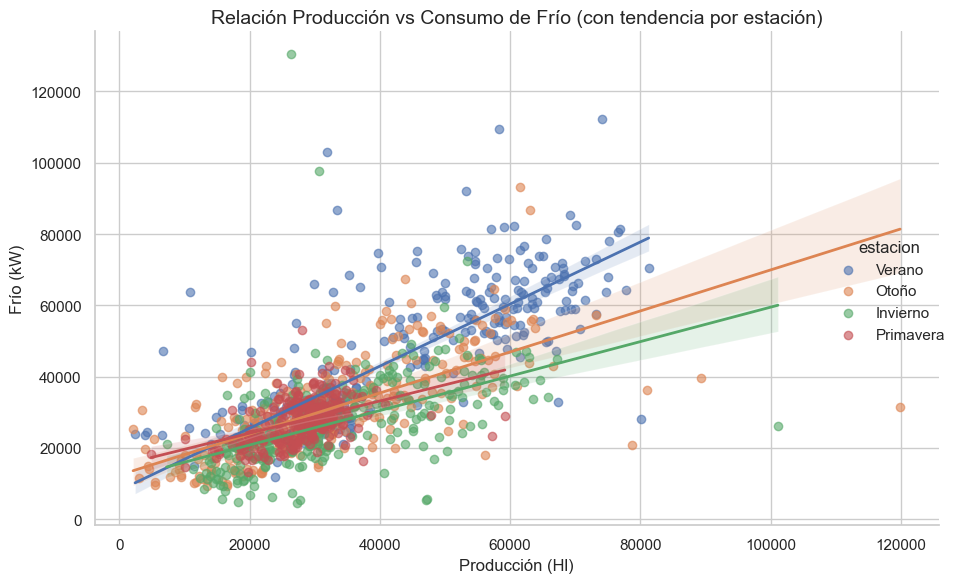

In [ ]:

sns.lmplot(
    data=df_limpio,
    x="Hl de Mosto",
    y="Frio (Kw) tomorrow",
    hue="estacion",
    height=6,
    aspect=1.4,
    scatter_kws={"alpha": 0.6},  
    line_kws={"lw": 2},          
)

plt.title("Relación Hl de Mosto vs Consumo de Frío (con tendencia por estación)", fontsize=14)
plt.xlabel("Hl de Mosto")
plt.ylabel("Frío (kW) tomorrow")
plt.tight_layout()
plt.show()



sns.lmplot(
    data=df_limpio,
    x="Produccion (Hl)",
    y="Frio (Kw) tomorrow",
    hue="estacion",
    height=6,
    aspect=1.4,
    scatter_kws={"alpha": 0.6},  # transparencia en los puntos
    line_kws={"lw": 2},          # grosor de las líneas
)

plt.title("Relación Producción vs Consumo de Frío (con tendencia por estación)", fontsize=14)
plt.xlabel("Producción (Hl)")
plt.ylabel("Frío (kW)")
plt.tight_layout()
plt.show()



# analisis de correlacíon

In [ ]:
df.select_dtypes(include=["number"]).columns

Index(['EE Planta / Hl', 'EE Elaboracion / Hl', 'EE Bodega / Hl',
       'EE Cocina / Hl', 'EE Envasado / Hl', 'EE Linea 2 / Hl',
       'EE Linea 3 / Hl', 'EE Linea 4 / Hl', 'EE Servicios / Hl',
       'EE Sala Maq / Hl',
       ...
       'Vapor _Vapor_L5 (KG)', 'Tot Fermantacion_Cocina',
       'Tot Reposo Inferior', 'Tot  Reposo Superior', 'Anio', 'Mes', 'Dia',
       'Temperatura_amb', 'Tarifa_electrica', 'Frio (Kw) tomorrow'],
      dtype='object', length=329)

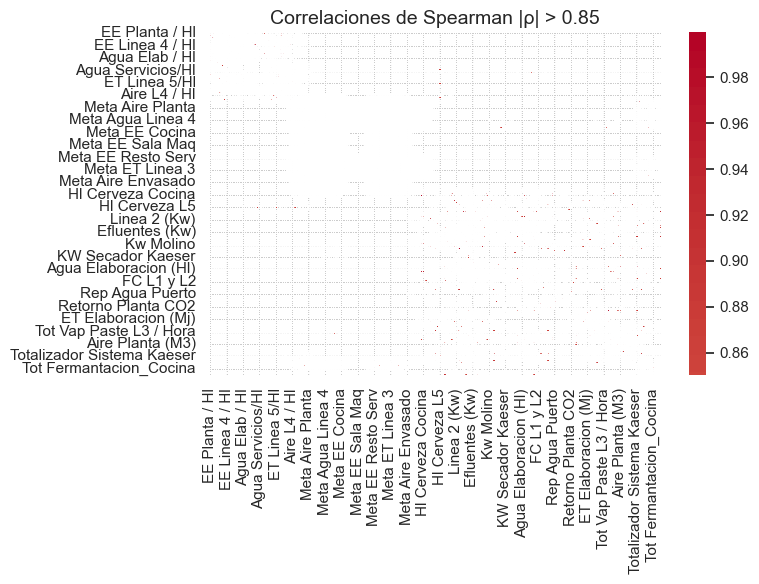

In [ ]:
# --- 0️⃣ Filtrar solo columnas numéricas ---
df_num = df.select_dtypes(include=["number"])

# --- 1️⃣ Calcular correlación de Spearman ---
corr = df_num.corr(method="spearman")
# --- 2️⃣ Filtrar correlaciones fuertes ---
strong_corr = corr[(corr.abs() > 0.85) & (corr.abs() < 1.0)]

# --- 3️⃣ Eliminar filas/columnas sin correlaciones fuertes ---
strong_corr = strong_corr.dropna(how="all", axis=0).dropna(how="all", axis=1)

# --- 4️⃣ Graficar si existen correlaciones ---
if not strong_corr.empty:
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        strong_corr,
        annot=True,
        cmap="coolwarm",
        center=0,
        fmt=".2f",
        linewidths=0.5
    )
    plt.title("Correlaciones de Spearman |ρ| > 0.85", fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No se encontraron correlaciones de Spearman con |ρ| > 0.85.")



Podemos identificar que algunas variables estan fuertemente correlacionada por lo que el modelo podrias "unificarlas". A su vez, hay variables como PLanta (Kw) o Tarifa_electrica que tienen una alta correlacion con el Frio.

Si filtramos las variables con una mayor correlación respecto al target obtenemos el siguiente resutlado.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

target = "Frio (Kw) tomorrow" 

# --- 1️⃣ Calcular correlaciones ---
corr_spearman = df.corr(method="spearman", numeric_only=True)
corr_target = corr_spearman[target].drop(target).sort_values(ascending=False)
corr_filtrada = corr_target[abs(corr_target) > 0.1]
top30 = corr_filtrada.abs().sort_values(ascending=False).head(100)

with pd.option_context('display.max_rows', None):
    print(top30)

"""
# --- 2️⃣ Mostrar en heatmap ---
if not corr_filtrada.empty:
    plt.figure(figsize=(4, len(corr_filtrada)*0.5 + 1))
    sns.heatmap(
        corr_filtrada.to_frame(name="Spearman"),
        annot=True,
        cmap="coolwarm",
        center=0,
        cbar=False,
        fmt=".2f"
    )
    plt.title(f"Correlaciones de Spearman con '{target}' (|ρ| > 0.70)", fontsize=13)
    plt.tight_layout()
    plt.show()
else:
    print(f"⚠️ No se encontraron correlaciones de Spearman con '{target}' mayores a 0.70.")
"""

Frio (Kw)                     0.839183
Sala Maq (Kw)                 0.828727
Servicios (Kw)                0.824880
KW Gral Planta                0.798001
Planta (Kw)                   0.797192
Agua Planta (Hl)              0.753549
Planta de agua (Hl)           0.749197
Tarifa_electrica              0.731619
KW Trafo 10                   0.730036
Produccion (Hl)               0.726342
Aire Producido (M3)           0.723074
Totalizador Sistema Kaeser    0.723074
Kw Compresores Aire           0.723005
Aire (Kw)                     0.712758
Elaboracion (Kw)              0.702511
Aire Planta (M3)              0.673949
Temp Tq Intermedio            0.673065
Pta Agua / Eflu (Kw)          0.668810
KW Secador Kaeser             0.666873
Bodega (Kw)                   0.666292
KW Trafo 11                   0.661614
KW Trafo 9                    0.657520
KW Trafo 5                    0.643800
Efluentes (Kw)                0.642222
Agua Cond REC                 0.640727
KW Enfluente Efl         

'\n# --- 2️⃣ Mostrar en heatmap ---\nif not corr_filtrada.empty:\n    plt.figure(figsize=(4, len(corr_filtrada)*0.5 + 1))\n    sns.heatmap(\n        corr_filtrada.to_frame(name="Spearman"),\n        annot=True,\n        cmap="coolwarm",\n        center=0,\n        cbar=False,\n        fmt=".2f"\n    )\n    plt.title(f"Correlaciones de Spearman con \'{target}\' (|ρ| > 0.70)", fontsize=13)\n    plt.tight_layout()\n    plt.show()\nelse:\n    print(f"⚠️ No se encontraron correlaciones de Spearman con \'{target}\' mayores a 0.70.")\n'

Esperaremos que estas variables en nuestro modelo sean las "Dominantes". Tal como vimos anteriormente, Planta (Kw) y Produccion (Hl) son variables donde notamos el patron similar con la evolución temporal del frio.

# Analisis de Valores nulos, negativos y ceros

Vamos a analizar como se comportan estos valores.

In [ ]:
def columnas_con_nan(df, nombre_archivo="columnas_con_nan.csv"):

    # Contar valores faltantes por columna
    nans_por_columna = df.isna().sum()
    
    # Filtrar solo las columnas con al menos un NaN
    columnas_con_nan = nans_por_columna[nans_por_columna > 0].sort_values(ascending=False)
    
    if columnas_con_nan.empty:
        print("✅ No hay columnas con valores faltantes.")
        return pd.DataFrame(columns=["columna", "cantidad_nan"])
    
    print(f"🔍 Se encontraron {len(columnas_con_nan)} columnas con valores faltantes:\n")
    print(columnas_con_nan)
    
    # Convertir a DataFrame más claro
    resultado = columnas_con_nan.reset_index()
    resultado.columns = ["columna", "cantidad_nan"]
    
    
    return resultado

# --- Ejemplo de uso ---
resultado = columnas_con_nan(df)


✅ No hay columnas con valores faltantes.


- No hay columnas con valroes faltantes pero hay dias faltantes en general en el dataset
- Tambien hay que pensar que las columnas con valroes cero o negativos muy probablemente sean errores (dependiendo que se esta midiendo)

In [ ]:
def columnas_con_negativos(df):

    df_num = df.select_dtypes(include=["number"])

    negativos = (df_num < 0).sum()

    cols_negativas = negativos[negativos > 0].sort_values(ascending=False)
    
    if cols_negativas.empty:
        print("✅ No se encontraron columnas con valores negativos.")
        return pd.DataFrame(columns=["columna", "cantidad_negativos"])
    else:
        print("⚠️ Columnas con valores negativos:")
        return cols_negativas.to_frame(name="cantidad_negativos")
    

def columnas_con_ceros(df):

    df_num = df.select_dtypes(include=["number"])

    negativos = (df_num == 0).sum()

    cols_negativas = negativos[negativos > 0].sort_values(ascending=False)
    
    if cols_negativas.empty:
        print("✅ No se encontraron columnas con valores cero.")
        return pd.DataFrame(columns=["columna", "cantidad_ceros"])
    else:
        print("⚠️ Columnas con valores cero:")
        return cols_negativas.to_frame(name="cantidad_ceros")


print(columnas_con_negativos(df))


print(columnas_con_ceros(df))

⚠️ Columnas con valores negativos:
                         cantidad_negativos
Resto Serv (Kw)                          44
EE Resto Serv / Hl                       43
Aire Servicios (M3)                      25
Aire Servicios / Hl                      24
Restos Planta (Kw)                       19
EE Resto Planta / Hl                     17
Prod Agua (Kw)                            7
Bodega (Kw)                               7
Linea 2 (Kw)                              6
Temp Tq Intermedio                        6
Pta Agua / Eflu (Kw)                      5
Agua Servicios/Hl                         5
EE Bodega / Hl                            5
EE Agua / Hl                              5
Agua Planta de Agua/Hl                    5
Agua Servicios (Hl)                       5
KW Filtr Carbon                           4
EE Linea 2 / Hl                           3
Tarifa_electrica                          2
Elaboracion (Kw)                          2
ET Linea 3/Hl                            

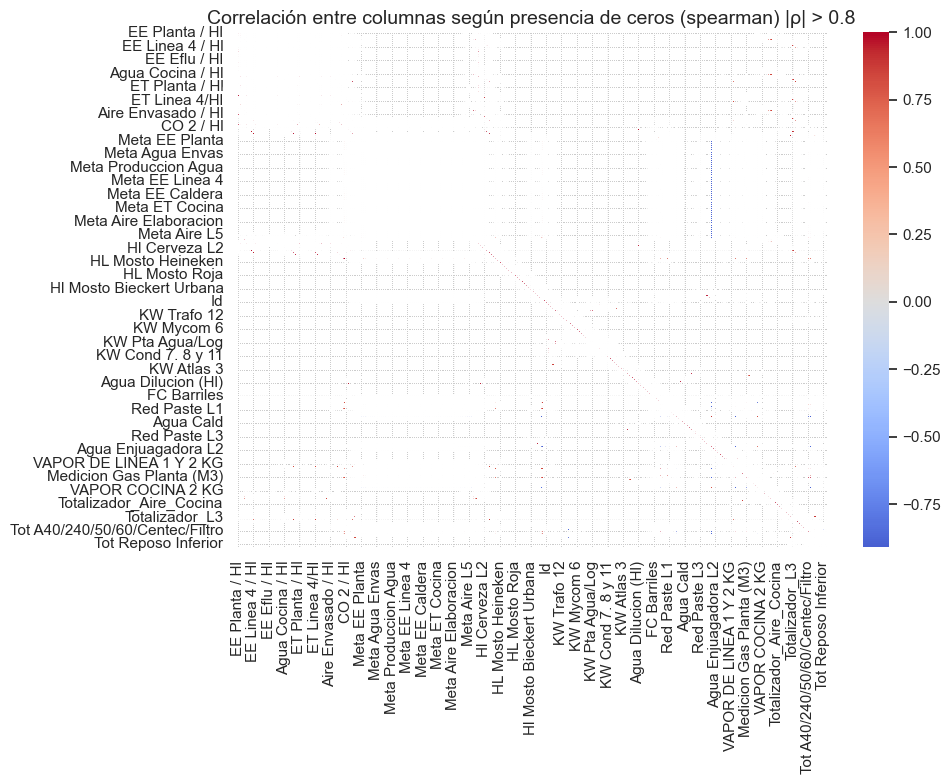

In [ ]:
# matriz de correlacion de CEROS
def matriz_correlacion_ceros(df, metodo="spearman", umbral=None):
    """
    Calcula y grafica la correlación entre columnas según la presencia de ceros.
    Parámetros:
      - df: DataFrame de entrada
      - metodo: método de correlación ('pearson', 'spearman', 'kendall')
      - umbral: si se indica, muestra solo correlaciones |ρ| > umbral
    """
    # Crear una máscara booleana: 1 si el valor es 0, 0 en caso contrario
    df_zeros = (df == 0).astype(int)
    
    # Calcular la correlación
    corr_zeros = df_zeros.corr(method=metodo)
    
    # Aplicar umbral si se pide
    if umbral is not None:
        corr_filtrada = corr_zeros[(corr_zeros.abs() > umbral) & (corr_zeros.abs() <= 1.0)]
        corr_filtrada = corr_filtrada.dropna(how="all", axis=0).dropna(how="all", axis=1)
    else:
        corr_filtrada = corr_zeros

    # Graficar
    if not corr_filtrada.empty:
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            corr_filtrada,
            annot=True,
            cmap="coolwarm",
            center=0,
            fmt=".2f",
            linewidths=0.5
        )
        titulo = f"Correlación entre columnas según presencia de ceros ({metodo})"
        if umbral is not None:
            titulo += f" |ρ| > {umbral}"
        plt.title(titulo, fontsize=14)
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ No se encontraron correlaciones de ceros que cumplan el umbral.")

    return corr_zeros

corr_zeros = matriz_correlacion_ceros(df, metodo="spearman", umbral=0.8)

Ignoramos las diagonales, hay correlaciones fuertes de valores nulos.